In [3]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [118]:
data_dir = 'cifar10'
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [119]:
os.getcwd()

'D:\\Coursera\\ProjectX'

In [120]:
train_x_dir = os.path.join(data_dir, 'train_x_' + str(1) + '.npy')
train_y_dir = os.path.join(data_dir, 'train_y_' + str(1) + '.npy')

train_x = np.load(train_x_dir)
train_y = np.load(train_y_dir)

test_x_dir = os.path.join(data_dir, 'test_x_6.npy')
test_y_dir = os.path.join(data_dir, 'test_y_6.npy')

test_x = np.load(test_x_dir)
test_y = np.load(test_y_dir)

### I'm trying to implement below model structure from the paper:
### http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks

![title]([cifar10 project] CNN model structure from paper.png)

### Network structure from paper:
### Conv_1 -> Max_pool_1 -> Conv_2 -> Max_pool_2 -> Conv_3 -> Conv_4 -> Conv_5 -> Max_pool_3
### -> Fully_conn_1 -> Fully_conn_2 -> Fully_conn_3

In [196]:
batch_size = 100
learning_rate = 0.1
evaluation_size = 500
image_width = 32
image_height = 32
target_size = len(labels)
num_channels = 3 
generations = 1000
eval_every = 5
conv1_features = 100
conv2_features = 50
conv3_features = 50
conv4_features = 50
conv5_features = 50


max_pool_size1 = 2 
max_pool_size2 = 2 
max_pool_size3 = 2 

fully_connected_size1 = 200
fully_connected_size2 = 200


In [122]:
crop_width = 28
crop_height = 28

In [123]:
sess = tf.Session()

In [124]:
# calculate prediction accuracy 
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return 100. * num_correct/batch_predictions.shape[0]

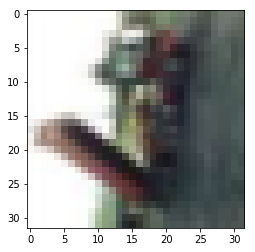

truck


In [143]:
plt.imshow(train_x[2])#, cmap='Greys_r')
plt.show()
print(labels[train_y[2]])

In [126]:
def model_build(input_data, conv1_weight, conv1_bias, conv2_weight, conv2_bias, conv3_weight, conv3_bias, conv4_weight, conv4_bias,conv5_weight, conv5_bias, full1_weight, full1_bias, full2_weight, full2_bias, full3_weight, full3_bias):

    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],
                               strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')

    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1],
                               strides=[1, max_pool_size2, max_pool_size2, 1], padding='SAME')
    
    conv3 = tf.nn.conv2d(max_pool2, conv3_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_bias))
    
    conv4 = tf.nn.conv2d(relu3, conv4_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu4 = tf.nn.relu(tf.nn.bias_add(conv4, conv4_bias))
    
    
    conv5 = tf.nn.conv2d(relu4, conv5_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu5 = tf.nn.relu(tf.nn.bias_add(conv5, conv5_bias))
    max_pool3 = tf.nn.max_pool(relu5, ksize=[1, max_pool_size3, max_pool_size3, 1],
                               strides=[1, max_pool_size3, max_pool_size3, 1], padding='SAME')
    
    
    final_conv_shape = max_pool3.get_shape().as_list()
    modified_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool3, [final_conv_shape[0], modified_shape])

    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    
    fully_connected2 = tf.nn.relu(tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias))
    
    model_output = tf.add(tf.matmul(fully_connected2, full3_weight), full3_bias)
    return model_output

In [129]:
def model_run(train_data, train_labels, test_data, test_labels, generations):
    x_input_shape = (batch_size, image_width, image_height, num_channels)
    x_input = tf.placeholder(tf.float32, shape=x_input_shape)
    y_target = tf.placeholder(tf.int32, shape=(batch_size))
    
    eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
    eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
    eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))
    
    conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features], stddev=0.1, dtype=tf.float32))
    conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))
    conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features], stddev=0.1, dtype=tf.float32))
    conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))
    conv3_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_features, conv3_features], stddev=0.1, dtype=tf.float32))
    conv3_bias = tf.Variable(tf.zeros([conv3_features], dtype=tf.float32))
    conv4_weight = tf.Variable(tf.truncated_normal([4, 4, conv3_features, conv4_features], stddev=0.1, dtype=tf.float32))
    conv4_bias = tf.Variable(tf.zeros([conv4_features], dtype=tf.float32))
    conv5_weight = tf.Variable(tf.truncated_normal([4, 4, conv4_features, conv5_features], stddev=0.1, dtype=tf.float32))
    conv5_bias = tf.Variable(tf.zeros([conv5_features], dtype=tf.float32))
    
    
    
    
    
    resulting_width = image_width // (max_pool_size1 * max_pool_size2 * max_pool_size3)
    resulting_height = image_height // (max_pool_size1 * max_pool_size2 * max_pool_size3)
    full1_input_size = resulting_width * resulting_height * conv5_features
    full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, fully_connected_size2], stddev=0.1, dtype=tf.float32))
    full2_bias = tf.Variable(tf.truncated_normal([fully_connected_size2], stddev=0.1, dtype=tf.float32))
    
    
    full3_weight = tf.Variable(tf.truncated_normal([fully_connected_size2, target_size], stddev=0.1, dtype=tf.float32))
    full3_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))
    
    model_output = model_build(x_input, conv1_weight, conv1_bias, conv2_weight, conv2_bias, conv3_weight, conv3_bias, conv4_weight, conv4_bias, conv5_weight, conv5_bias, full1_weight, full1_bias, full2_weight, full2_bias, full3_weight, full3_bias)
    test_model_output = model_build(eval_input, conv1_weight, conv1_bias, conv2_weight, conv2_bias, conv3_weight, conv3_bias, conv4_weight, conv4_bias, conv5_weight, conv5_bias, full1_weight, full1_bias, full2_weight, full2_bias, full3_weight, full3_bias)
    
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))
    
    my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_step = my_optimizer.minimize(loss)

    # Initialize Variables
    init = tf.global_variables_initializer()
    sess.run(init)
    
    print('model running')
    
    prediction = tf.nn.softmax(model_output)
    test_prediction = tf.nn.softmax(test_model_output)
    
    train_loss = []
    train_acc = []
    test_acc = []
    for i in range(generations):
        rand_index = np.random.choice(len(train_data), size=batch_size)
        rand_x = train_data[rand_index]
        #rand_x = np.expand_dims(rand_x, 3)
        rand_y = train_labels[rand_index]
        train_dict = {x_input: rand_x, y_target: rand_y}
        sess.run(train_step, feed_dict=train_dict)
        
        temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
        temp_train_acc = get_accuracy(temp_train_preds, rand_y)

        if (i+1) % eval_every == 0:
            eval_index = np.random.choice(len(test_data), size=evaluation_size)
            eval_x = test_data[eval_index]
            #eval_x = np.expand_dims(eval_x, 3)
            eval_y = test_labels[eval_index]
            test_dict = {eval_input: eval_x, eval_target: eval_y}
            test_preds = sess.run(test_prediction, feed_dict=test_dict)
            temp_test_acc = get_accuracy(test_preds, eval_y)

            # Record and print results
            train_loss.append(temp_train_loss)
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
            acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
        if (i+1) % eval_every  == 0:
            print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
    return train_loss, train_acc, test_acc


In [150]:
learning_rate = 0.00005
batch_size = 100

train_loss, train_acc, test_acc = model_run(train_x, train_y, test_x, test_y, generations)


model running
Generation # 5. Train Loss: 245.72. Train Acc (Test Acc): 7.00 (9.00)
Generation # 10. Train Loss: 11.90. Train Acc (Test Acc): 13.00 (9.80)
Generation # 15. Train Loss: 8.27. Train Acc (Test Acc): 15.00 (11.00)
Generation # 20. Train Loss: 4.23. Train Acc (Test Acc): 6.00 (11.60)
Generation # 25. Train Loss: 3.09. Train Acc (Test Acc): 8.00 (10.60)
Generation # 30. Train Loss: 2.52. Train Acc (Test Acc): 11.00 (10.40)
Generation # 35. Train Loss: 2.39. Train Acc (Test Acc): 15.00 (9.60)
Generation # 40. Train Loss: 2.34. Train Acc (Test Acc): 11.00 (11.60)
Generation # 45. Train Loss: 2.32. Train Acc (Test Acc): 14.00 (10.80)
Generation # 50. Train Loss: 2.39. Train Acc (Test Acc): 13.00 (10.80)
Generation # 55. Train Loss: 2.36. Train Acc (Test Acc): 13.00 (13.20)
Generation # 60. Train Loss: 2.25. Train Acc (Test Acc): 11.00 (10.60)


KeyboardInterrupt: 

In [ ]:
final_image = tf.image.resize_image_with_crop_or_pad

In [34]:
a = tf.image.per_image_standardization(train_x[0])

In [46]:

a

<tf.Tensor 'per_image_standardization:0' shape=(32, 32, 3) dtype=float32>

In [152]:
def model_build_simple(input_data, conv1_weight, conv1_bias, full1_weight, full1_bias, full2_weight, full2_bias):
    #print(input_data)
    #print(conv1_weight)

    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],
                               strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')

    
    norm1 = tf.nn.lrn(max_pool1, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75)

    
    final_conv_shape = norm1.get_shape().as_list()
    modified_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool1, [final_conv_shape[0], modified_shape])

    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    
    model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    return model_output

In [169]:
def model_run_simple(train_data, train_labels, test_data, test_labels, generations):
    x_input_shape = (batch_size, image_width, image_height, num_channels)
    
    x_input = tf.placeholder(tf.float32, shape=x_input_shape)
    
    y_target = tf.placeholder(tf.int32, shape=(batch_size))
    
    eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
    eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
    eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))
    
    conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features], stddev=0.1, dtype=tf.float32))
    conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))
    
    
    
    
    resulting_width = image_width // (max_pool_size1)
    resulting_height = image_height // (max_pool_size1)
    full1_input_size = resulting_width * resulting_height * conv1_features
    full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
    
    full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
    full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))
    
    model_output = model_build_simple(x_input, conv1_weight, conv1_bias, full1_weight, full1_bias, full2_weight, full2_bias)
    test_model_output = model_build_simple(eval_input, conv1_weight, conv1_bias, full1_weight, full1_bias, full2_weight, full2_bias)
    
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))
    
    my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_step = my_optimizer.minimize(loss)

    # Initialize Variables
    init = tf.global_variables_initializer()
    sess.run(init)
    
    print('model running')
    
    prediction = tf.nn.softmax(model_output)
    test_prediction = tf.nn.softmax(test_model_output)
    
    train_loss = []
    train_acc = []
    test_acc = []
    for i in range(generations):
        rand_index = np.random.choice(len(train_data), size=batch_size)
        rand_x = train_data[rand_index]
        #rand_x = np.expand_dims(rand_x, 3)
        rand_y = train_labels[rand_index]
        train_dict = {x_input: rand_x, y_target: rand_y}
        sess.run(train_step, feed_dict=train_dict)
        temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
        temp_train_acc = get_accuracy(temp_train_preds, rand_y)

        if (i+1) % eval_every == 0:
            #eval_index = np.random.choice(len(test_data), size=evaluation_size)
            #eval_x = test_data[eval_index]
            #eval_y = test_labels[eval_index]
            #test_dict = {eval_input: eval_x, eval_target: eval_y}
            #test_preds = sess.run(test_prediction, feed_dict=test_dict)
            temp_test_acc = 0 # get_accuracy(test_preds, eval_y)

            # Record and print results
            train_loss.append(temp_train_loss)
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
            acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
        if (i+1) % (eval_every ) == 0:
            print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
    return train_loss, train_acc, test_acc


In [170]:
train_x.shape

(10000, 32, 32, 3)

In [171]:
learning_rate = 0.0001
batch_size = 100

train_loss, train_acc, test_acc = model_run_simple(train_x, train_y, test_x, test_y, generations)

model running


KeyboardInterrupt: 

In [184]:
def model_1_build(input_data, full1_weight, full1_bias, full2_weight, full2_bias):
    # Transform data to 1*N for fully connected NN
    input_data_shape = input_data.get_shape().as_list()
    modified_shape = input_data_shape[1] * input_data_shape[2] * input_data_shape[3] 
    flat_data = tf.reshape(input_data, [input_data_shape[0], modified_shape])
    print(flat_data)
    print(full1_weight)
    # Fully Connected Layer 1
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_data, full1_weight), full1_bias))

    # Fully Connected Layer 2
    model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    return model_output

In [190]:
def model_1(train_data, train_labels, test_data, test_labels, generations):
    # set up placeholders
    x_input_shape = (batch_size, image_width, image_height, num_channels)
    x_input = tf.placeholder(tf.float32, shape=x_input_shape)
    y_target = tf.placeholder(tf.int32, shape=(batch_size))
    
    eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
    eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
    eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))
    
    # set up variables
    resulting_width = image_width
    resulting_height = image_height
    full1_input_size = resulting_width * resulting_height * num_channels
    full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
    full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
    full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))
    
    # outputs and loss
    model_output = model_1_build(x_input, full1_weight, full1_bias, full2_weight, full2_bias)
    test_model_output = model_1_build(eval_input, full1_weight, full1_bias, full2_weight, full2_bias)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))
    
    my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_step = my_optimizer.minimize(loss)

    # Initialize Variables
    init = tf.global_variables_initializer()
    sess.run(init)
    
    print('model 1 (full_conn_1 -> full_connect_2 -> predictions)')
    
    prediction = tf.nn.softmax(model_output)
    test_prediction = tf.nn.softmax(test_model_output)
    
    train_loss = []
    train_acc = []
    test_acc = []
    
    for i in range(generations):
        rand_index = np.random.choice(len(train_data), size=batch_size)
        rand_x = train_data[rand_index]
        #rand_x = np.expand_dims(rand_x, 3)
        rand_y = train_labels[rand_index]
        train_dict = {x_input: rand_x, y_target: rand_y}
        sess.run(train_step, feed_dict=train_dict)
        
        temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
        temp_train_acc = get_accuracy(temp_train_preds, rand_y)

        if (i+1) % eval_every == 0:
            eval_index = np.random.choice(len(test_data), size=evaluation_size)
            eval_x = test_data[eval_index]
            #eval_x = np.expand_dims(eval_x, 3)
            eval_y = test_labels[eval_index]
            test_dict = {eval_input: eval_x, eval_target: eval_y}
            test_preds = sess.run(test_prediction, feed_dict=test_dict)
            temp_test_acc = get_accuracy(test_preds, eval_y)

            # Record and print results
            train_loss.append(temp_train_loss)
            train_acc.append(temp_train_acc)
            test_acc.append(temp_test_acc)
            acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
            acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
            print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
    return train_loss, train_acc, test_acc


In [197]:
learning_rate = 0.1
batch_size = 500
generations = 1000
train_loss_1, train_acc_1, test_acc_1 = model_1(train_x, train_y, test_x, test_y, generations)

Tensor("Reshape_69:0", shape=(500, 3072), dtype=float32)
<tf.Variable 'Variable_396:0' shape=(3072, 200) dtype=float32_ref>
Tensor("Reshape_70:0", shape=(500, 3072), dtype=float32)
<tf.Variable 'Variable_396:0' shape=(3072, 200) dtype=float32_ref>
model 1 (full_conn_1 -> full_connect_2 -> predictions)
Generation # 5. Train Loss: 2.31. Train Acc (Test Acc): 9.80 (9.80)
Generation # 10. Train Loss: 2.34. Train Acc (Test Acc): 8.20 (9.80)
Generation # 15. Train Loss: 2.32. Train Acc (Test Acc): 9.80 (10.60)
Generation # 20. Train Loss: 2.32. Train Acc (Test Acc): 11.40 (9.80)
Generation # 25. Train Loss: 2.31. Train Acc (Test Acc): 9.60 (9.40)
Generation # 30. Train Loss: 2.31. Train Acc (Test Acc): 9.20 (8.40)
Generation # 35. Train Loss: 2.30. Train Acc (Test Acc): 11.60 (9.60)
Generation # 40. Train Loss: 2.30. Train Acc (Test Acc): 6.60 (10.60)
Generation # 45. Train Loss: 2.30. Train Acc (Test Acc): 8.80 (11.40)
Generation # 50. Train Loss: 2.30. Train Acc (Test Acc): 9.40 (9.40)
Gen

Generation # 565. Train Loss: 2.31. Train Acc (Test Acc): 8.80 (9.40)
Generation # 570. Train Loss: 2.30. Train Acc (Test Acc): 9.60 (13.00)
Generation # 575. Train Loss: 2.30. Train Acc (Test Acc): 9.20 (9.20)
Generation # 580. Train Loss: 2.30. Train Acc (Test Acc): 7.40 (12.20)
Generation # 585. Train Loss: 2.31. Train Acc (Test Acc): 10.20 (9.80)
Generation # 590. Train Loss: 2.30. Train Acc (Test Acc): 12.60 (11.20)
Generation # 595. Train Loss: 2.30. Train Acc (Test Acc): 13.40 (10.60)
Generation # 600. Train Loss: 2.30. Train Acc (Test Acc): 9.20 (9.20)
Generation # 605. Train Loss: 2.30. Train Acc (Test Acc): 10.80 (9.60)
Generation # 610. Train Loss: 2.30. Train Acc (Test Acc): 10.00 (9.80)
Generation # 615. Train Loss: 2.30. Train Acc (Test Acc): 9.00 (8.20)
Generation # 620. Train Loss: 2.30. Train Acc (Test Acc): 9.20 (12.40)
Generation # 625. Train Loss: 2.30. Train Acc (Test Acc): 6.80 (10.20)
Generation # 630. Train Loss: 2.31. Train Acc (Test Acc): 8.00 (9.40)
Generatio